## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания со значением метрики *RMSE* на тестовой выборке не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split #импортируем функцию train_test_split из библиотеки sklearn 

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import r2_score
 

from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#прочитаем файл с исходными данными df

df = pd.read_csv("/datasets/taxi.csv", parse_dates=[0]) 

In [3]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
#удалим дубликаты

df = df.drop_duplicates().reset_index(drop = True)

In [6]:
#проверим отсутствие дубликатов

df.duplicated().sum()

0

In [7]:
#переведем столбец в формат даты
df.datetime = pd.to_datetime(df.datetime)

In [8]:
df=df.set_index('datetime')

In [9]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [10]:
#Отсортируем индекс таблицы
df.sort_index(axis = 0, ascending = True)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [11]:
#проверим правильно ли отсортировался индекс
df.index.is_monotonic

True

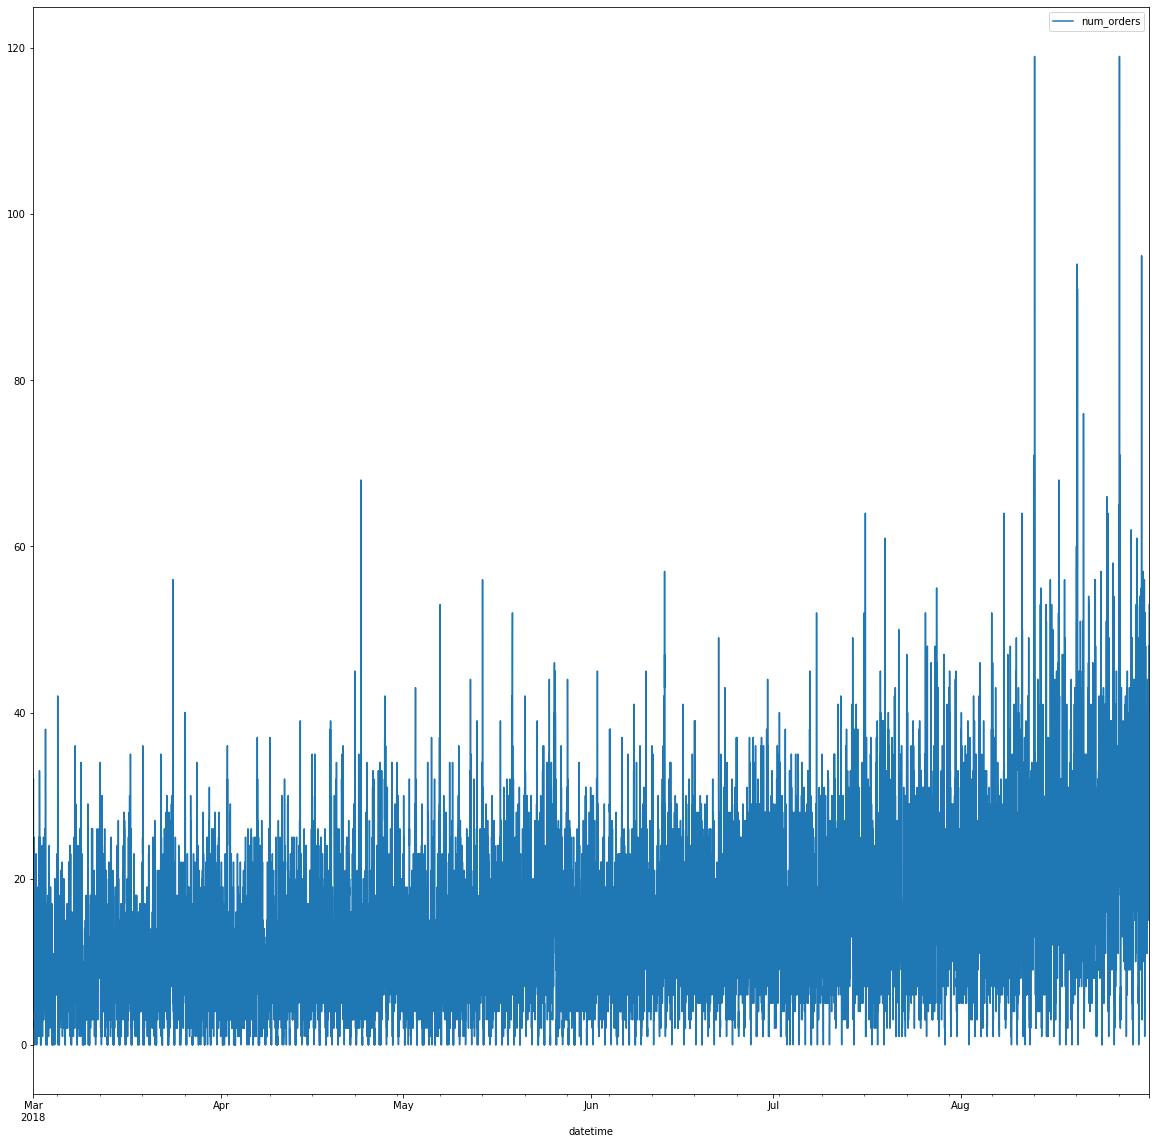

In [12]:
#Построим график временного ряда
df.plot(figsize=(20,20))

In [13]:
df_r=df.resample('1H').sum()

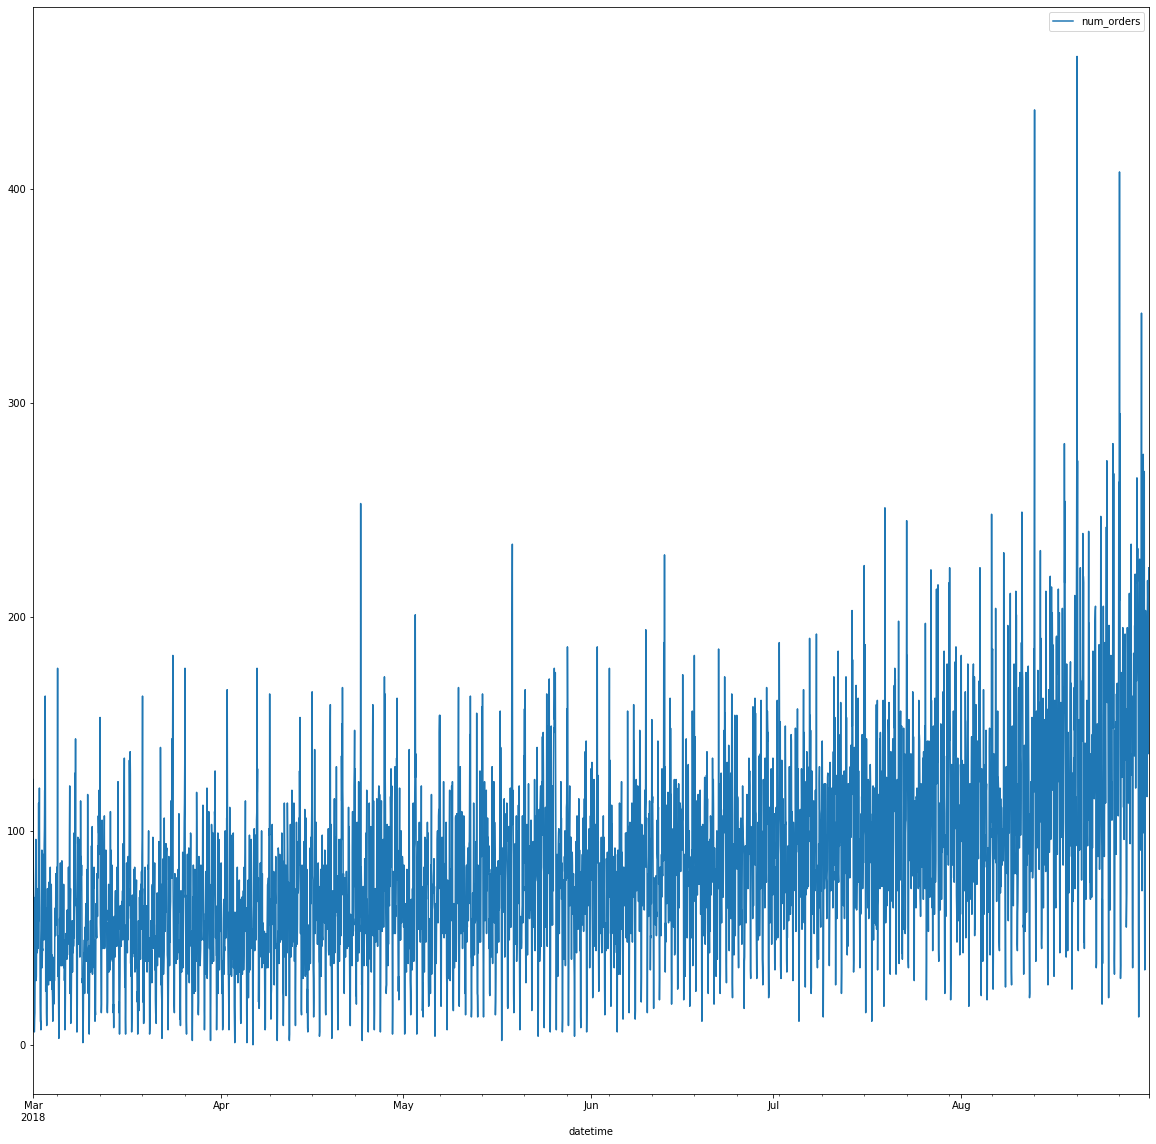

In [14]:
df_r.plot(figsize=(20,20))

Вывод: данные прошли предобработку, провели ресемплинг по 1 часу, построили график

# 2. Анализ

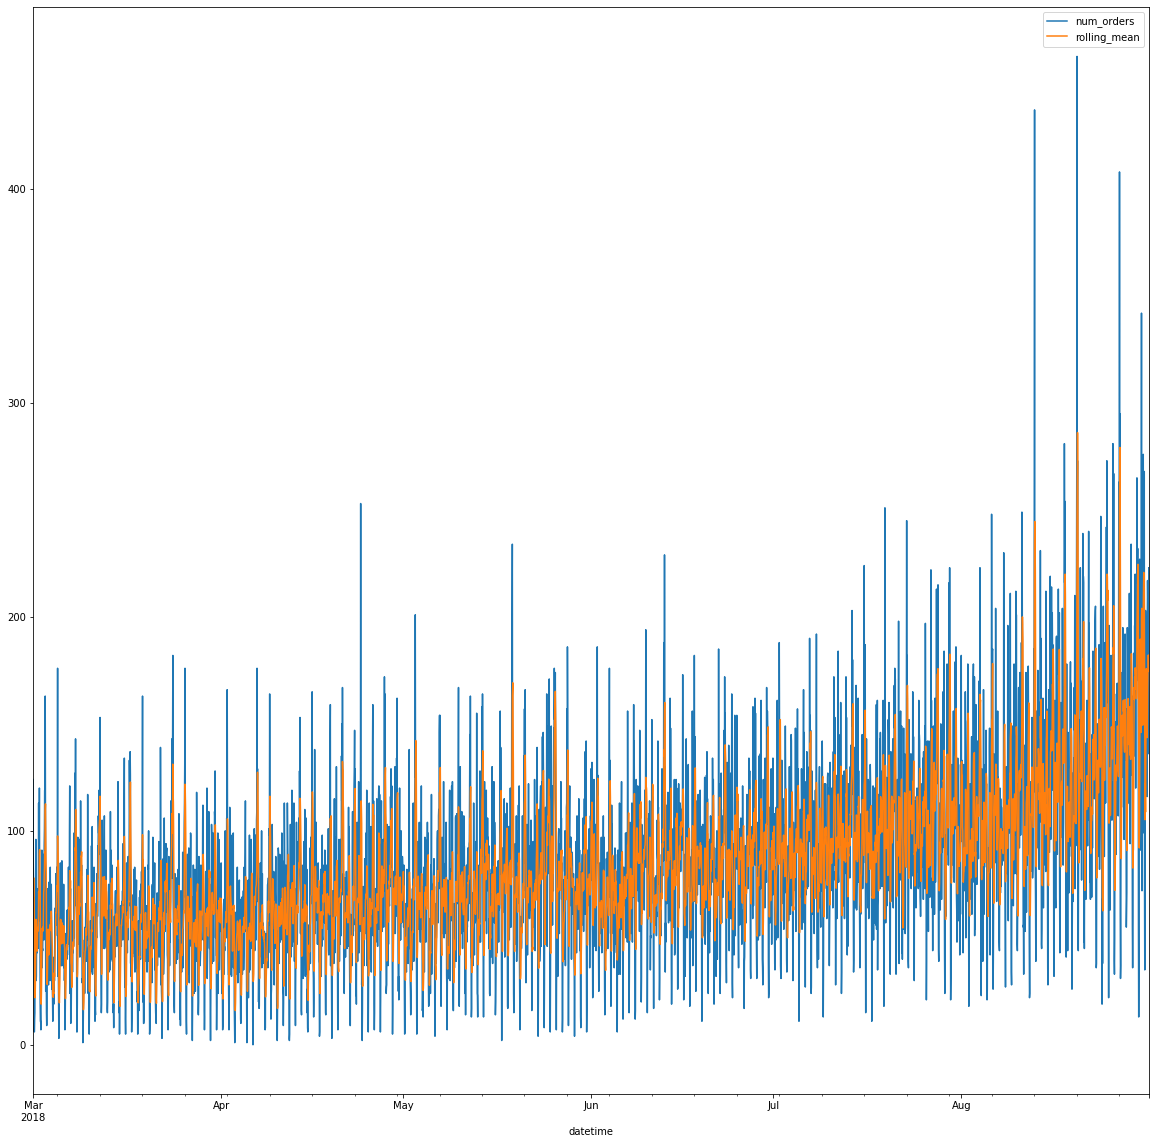

In [15]:
#Чтобы во временном ряду снизить колебания, применим скользящее среднее. С размером окна - выберем по ходу
df_r['rolling_mean']=df_r.rolling(5).mean()
df_r.plot(figsize=(20,20))

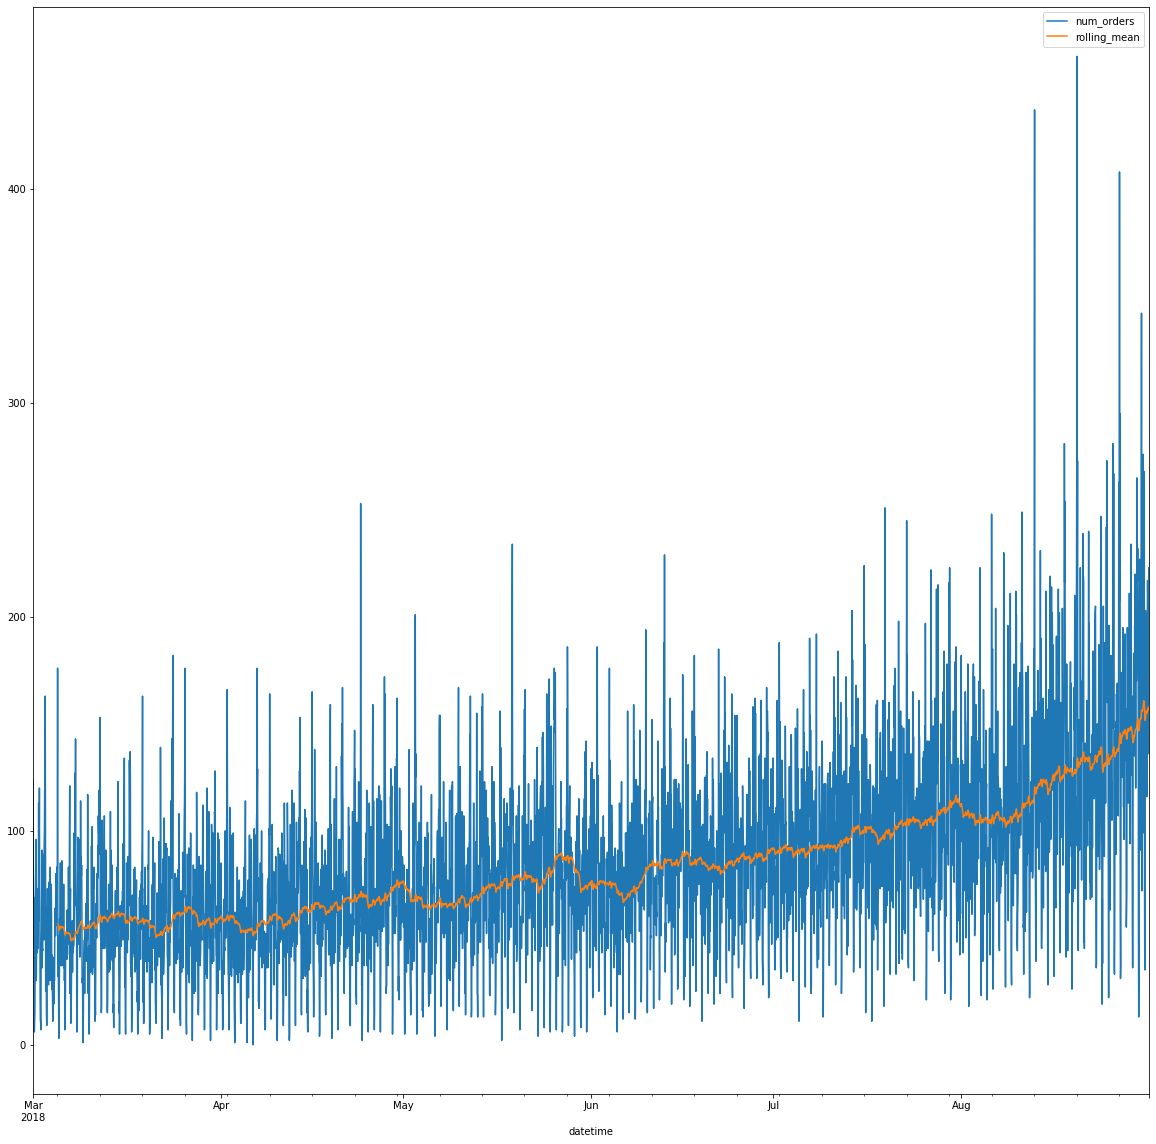

In [16]:
df_r['rolling_mean']=df_r.rolling(100).mean()
df_r.plot(figsize=(20,20))

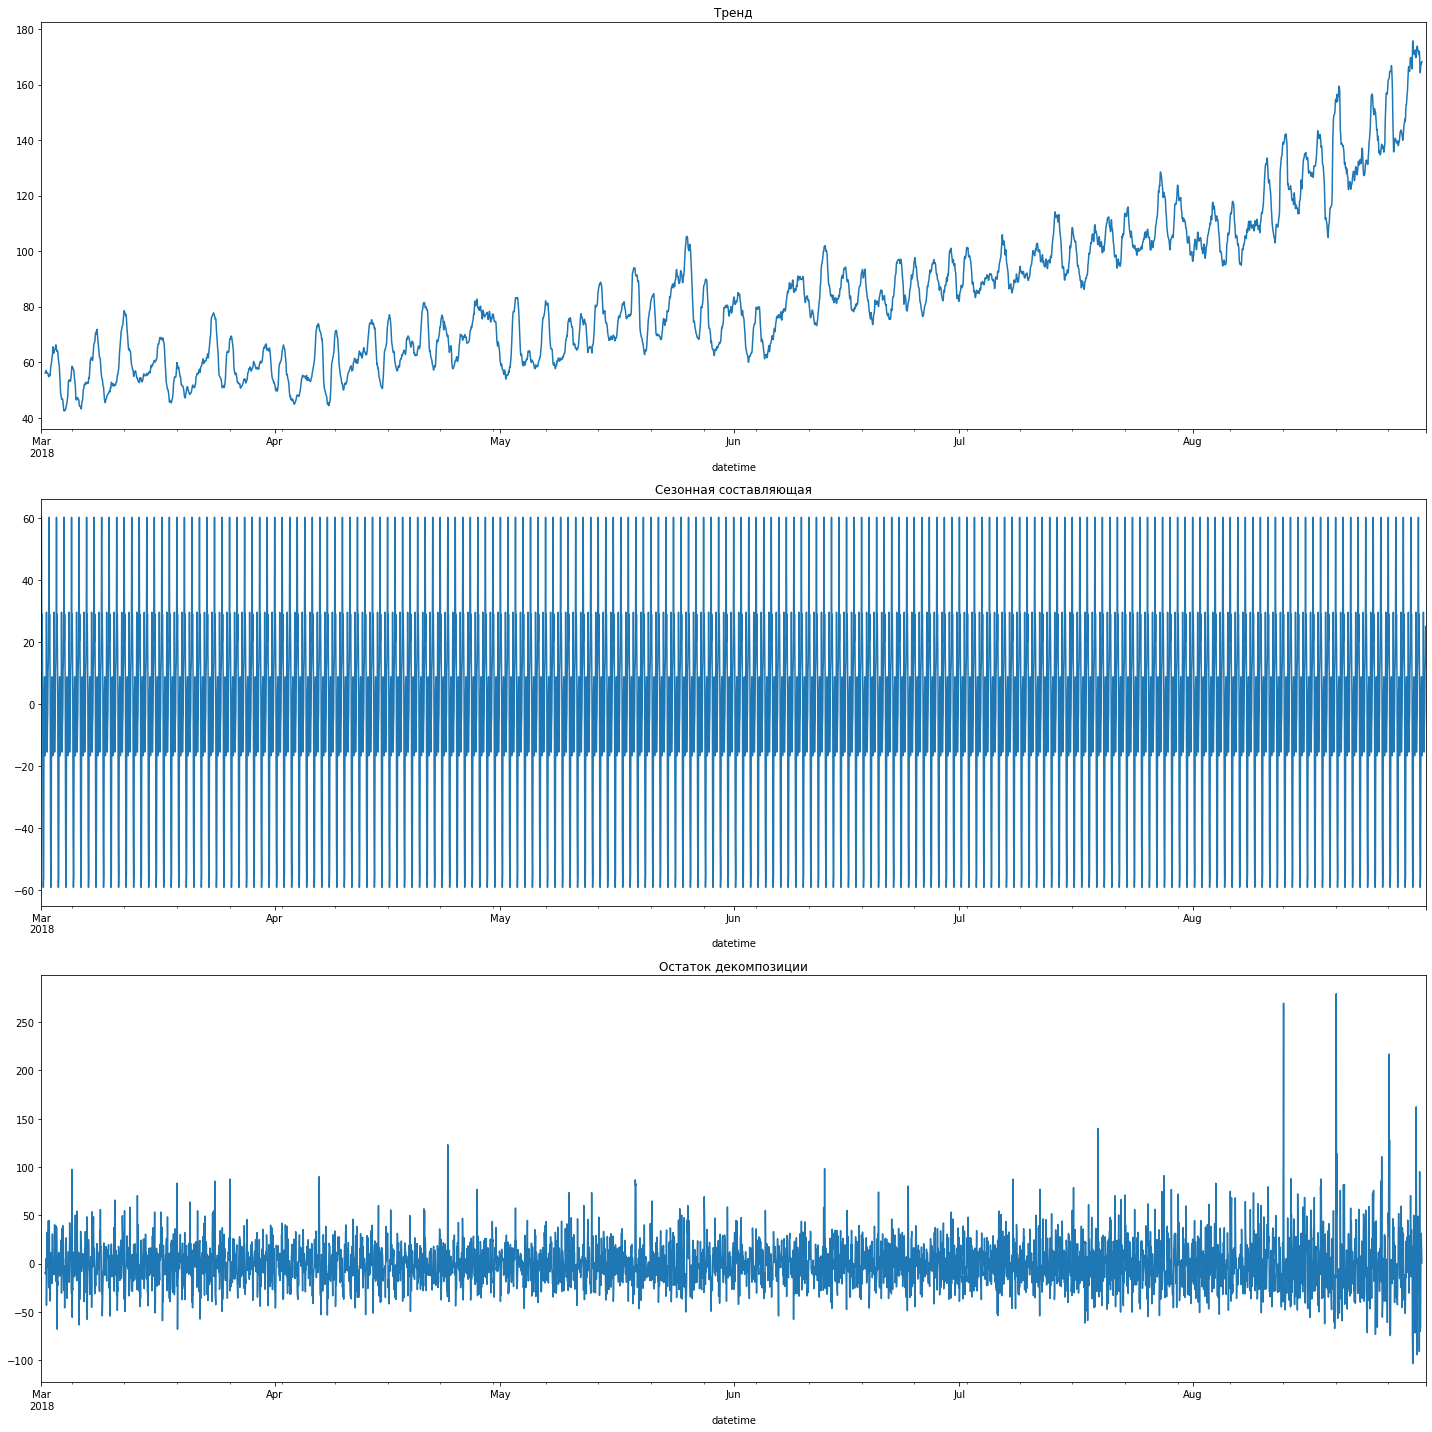

In [17]:
#Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df_r['num_orders'])

plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()


Вывод: ряд не стационарен, есть сезонность

# 3. Обучение

In [18]:
# создадим функцию, которая создает признаки год, месяц, день, день недели, 
# признак со значениями сдвигов, скользящее среднее с заданным окном

def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [19]:
df_f = make_features(df, 24, 100)

In [20]:
df_f.shape

(26496, 30)

In [21]:
#удилим все нан, которые образовались при сдвиге

df_f=df_f.dropna()

In [22]:
df_f.shape

(26396, 30)

In [23]:
# разделим выборки на обучающую и тестовую

train, test = train_test_split(df_f, shuffle=False, test_size=0.1)

In [24]:
# проверим, не спутались ли у нас значения временных рядов, их последовательность

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())


2018-03-01 16:40:00 2018-08-13 15:50:00
2018-08-13 16:00:00 2018-08-31 23:50:00


In [25]:
train.head()

,num_orders,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 16:40:00,9,2018,3,1,3,8.0,8.0,6.0,6.0,9.0,11.0,19.0,16.0,7.0,4.0,3.0,5.0,6.0,16.0,13.0,5.0,0.0,5.0,1.0,9.0,9.0,8.0,3.0,3.0,8.89
2018-03-01 16:50:00,6,2018,3,1,3,9.0,8.0,8.0,6.0,6.0,9.0,11.0,19.0,16.0,7.0,4.0,3.0,5.0,6.0,16.0,13.0,5.0,0.0,5.0,1.0,9.0,9.0,8.0,3.0,8.89
2018-03-01 17:00:00,5,2018,3,1,3,6.0,9.0,8.0,8.0,6.0,6.0,9.0,11.0,19.0,16.0,7.0,4.0,3.0,5.0,6.0,16.0,13.0,5.0,0.0,5.0,1.0,9.0,9.0,8.0,8.81
2018-03-01 17:10:00,7,2018,3,1,3,5.0,6.0,9.0,8.0,8.0,6.0,6.0,9.0,11.0,19.0,16.0,7.0,4.0,3.0,5.0,6.0,16.0,13.0,5.0,0.0,5.0,1.0,9.0,9.0,8.58
2018-03-01 17:20:00,9,2018,3,1,3,7.0,5.0,6.0,9.0,8.0,8.0,6.0,6.0,9.0,11.0,19.0,16.0,7.0,4.0,3.0,5.0,6.0,16.0,13.0,5.0,0.0,5.0,1.0,9.0,8.45


In [26]:
# найдем для выборок признаки и целевой признак

features_train = train.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)
 
target_train = train['num_orders']
target_test = test['num_orders']


In [27]:
#Произведем масштабирование 
numeric = ['year', 'month', 'day', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean' ]

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [28]:
#обучим модель линейной регрессии

model_LR = LinearRegression().fit(features_train,target_train)

In [29]:
#найдем лучшие гиперпараметры для модели случайного леса при помощи grid search

model_RF = RandomForestRegressor()

grid_RF = {'max_depth': [10, 100],
           'n_estimators': [200, 500]}


rf_random = RandomizedSearchCV(estimator = model_RF, param_distributions = grid_RF, scoring='neg_mean_squared_error', cv = 3)

#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [31]:
RF_random_results = rf_random.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(RF_random_results.best_params_))

BEST PARAMETERS: {'n_estimators': 500, 'max_depth': 10}


In [41]:
#обучим модель случайного леса с лучшими гиперпараметрами

model_RF = RandomForestRegressor(max_depth =10 , n_estimators =500 )
model_RF.fit(features_train,target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [33]:
#обучим модель xgboost с лучшими гиперпараметрами

from xgboost import XGBRegressor 

model_XGB = XGBRegressor()

grid_XGB = {'max_depth': [1, 6],
           'n_estimators': [50, 500]}

#base_score=0.5, booster='gbtree', colsample_bylevel=1,
 #      colsample_bytree=1, gamma=0, importance_type='gain',
  #     learning_rate=0.1, max_delta_step=0, max_depth=3,
   #    min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
    #   nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
     #  reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
      # subsample=1)
    
XGB_random = RandomizedSearchCV(estimator = model_XGB, param_distributions = grid_XGB, scoring='neg_mean_squared_error', cv = 3, verbose=2, n_jobs = -1)   

In [34]:
XGB_random_results = XGB_random.fit(features_train, target_train) 

In [35]:
print("BEST PARAMETERS: " + str(XGB_random_results.best_params_))

In [36]:
model_XGB = XGBRegressor(max_depth = 6, n_estimators = 50 )

In [37]:
# обучим модель xgboost

model_XGB.fit(features_train,target_train)

[16:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# 4. Тестирование

In [38]:
%%time

# протестируем линейную регрессию

predict_LR = model_LR.predict(features_test)
rmse_LR = mean_squared_error(target_test, predict_LR)**0.5
rmse_LR

CPU times: user 1.9 ms, sys: 7.96 ms, total: 9.85 ms
Wall time: 3.49 ms


8.469856217927628

In [42]:
%%time

# протестируем модель случайного леса

predict_RF = model_RF.predict(features_test)
rmse_RF = mean_squared_error(target_test, predict_RF)**0.5
rmse_RF

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 206 ms


8.610280913508156

In [43]:
%%time

# протестируем модель xgboost

predict_XGB = model_XGB.predict(features_test)
rmse_XGB = mean_squared_error(target_test, predict_XGB)**0.5
rmse_XGB

CPU times: user 3.39 ms, sys: 12 ms, total: 15.4 ms
Wall time: 13.7 ms


8.936254991380457

Вывод: модель xgboost лучше всех показала себя на тестовой выборке.